In [1]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

merged_data = pd.read_pickle('/content/drive/MyDrive/data_btc_1min.pickle')


Adding indicators

In [2]:
merged_data['volume'] = merged_data['volume'].astype(float)
merged_data['Volatility'] = merged_data['close'].pct_change(fill_method=None).rolling(5).std().fillna(0)

# Calculate Moving Averages
merged_data['SMA_5'] = merged_data['close'].rolling(window=5).mean()
merged_data['EMA_5'] = merged_data['close'].ewm(span=5, adjust=False).mean()
merged_data['SMA_10'] = merged_data['close'].rolling(window=10).mean()
merged_data['EMA_10'] = merged_data['close'].ewm(span=10, adjust=False).mean()
merged_data['SMA_20'] = merged_data['close'].rolling(window=20).mean()
merged_data['EMA_20'] = merged_data['close'].ewm(span=20, adjust=False).mean()
merged_data['EMA_50'] = merged_data['close'].ewm(span=50, adjust=False).mean()
merged_data['SMA_100'] = merged_data['close'].rolling(window=100).mean()
merged_data['EMA_100'] = merged_data['close'].ewm(span=100, adjust=False).mean()
merged_data['EMA_200'] = merged_data['close'].ewm(span=200, adjust=False).mean()

# Calculate Bollinger Bands
merged_data['Std_20'] = merged_data['close'].rolling(window=20).std()
merged_data['Upper_BB'] = merged_data['SMA_20'] + (2 * merged_data['Std_20'])
merged_data['Lower_BB'] = merged_data['SMA_20'] - (2 * merged_data['Std_20'])
merged_data['Daily_Returns'] = 100*(merged_data['close'].pct_change())

# Add a Signal column (e.g., 1 if Close > SMA_20, else 0)
# Calculate MACD and Signal Line
# MACD Line = 12-period EMA - 26-period EMA
merged_data['EMA_12'] = merged_data['close'].ewm(span=12, adjust=False).mean()
merged_data['EMA_26'] = merged_data['close'].ewm(span=26, adjust=False).mean()
merged_data['MACD'] = merged_data['EMA_12'] - merged_data['EMA_26']

# Signal Line = 9-period EMA of MACD Line
merged_data['Signal'] = merged_data['MACD'].ewm(span=9, adjust=False).mean()

Create Target

0.5631694502704105
0.43683054972958946


<Axes: >

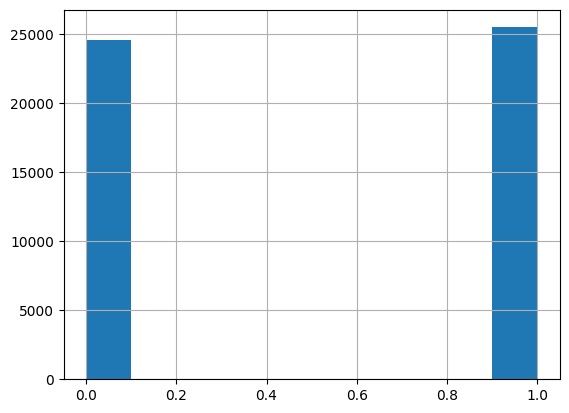

In [3]:
df = merged_data[['open', 'high', 'low', 'close', 'volume',
       'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
       'takerBuyQuoteVol', 'ignore', 'Volatility', 'SMA_5', 'EMA_5', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'EMA_50', 'SMA_100', 'EMA_100', 'EMA_200',
       'Std_20', 'Upper_BB', 'Lower_BB', 'Daily_Returns', 'EMA_12', 'EMA_26',
       'MACD', 'Signal']].copy()

for x in df.columns:
  df[x] = df[x].astype(float)

list_cols = df.columns

df['prev_return'] = 100*((df['close']-df['close'].shift(1))/df['close'])
# df['return'] = ((df['close'].shift(-1)-df['close'])/df['close'])
df
# df['return'] = (df['volume'].shift(1)+df['volume'].shift(2)+df['volume'].shift(3))
# df['return'] = df['return']-df['return'].mean()
# df['return'] = df['return']/df['return'].std()
df['return'] = 100*df['close'].pct_change()
df['volatility'] = 10*df['return'].rolling(30).std().shift(-30)

for x in list_cols:
  tmp = df[x]-df[x].mean()
  df[x] = tmp/tmp.std()

# df['return'] = (df['volume'].shift(1)+df['volume'].shift(2)+df['volume'].shift(3))
# df['return'] = (df['volume'].shift(1)-df['volume'].shift(2))
# df['return'] = 20*(df['close'].shift(1)-df['close'].shift(2))
# df['return'] = 20*(df['close'].shift(-1)-df['close'])
# df['return'] = 100*(df['close'].shift(-5)-df['close'])/df['close']

# df['return1'] = abs(100*((df['high'].rolling(5).max().shift(-5)-df['close'])/df['close']))
# df['return2'] = abs(100*((df['low'].rolling(5).min().shift(-5)-df['close'])/df['close']))
# df['return'] = df[['return1', 'return2']].max(axis=1)

# df['return'] = 10*df['close'].rolling(15).std().shift(-15)


# df['return'] = 100*(df['close'].shift(-1)-df['close'])/df['close']


# df['return'] = ((df['volume'].shift(2)-df['volume'].shift(3))/df['volume'].shift(3))
# df['return'] = (100*((df['close'].shift(-1440*7)-df['close'])/df['close'])).fillna(0)
# df['return'] = 100*((df['volume'].shift(2)-df['volume'].shift(3))/df['volume'].shift(3))
# df['return'] = (1*((df['volume'].shift(-1440)-df['volume'])/df['volume'])).fillna(0)
# df['return2'] = (100*((df['close'].shift(-1)-df['close'])/df['close'])).fillna(0)


df = df.fillna(0)

# threshold = 0.048
# df['return_class'] = 0
# df.loc[df['return']>threshold, 'return_class'] = 1
# df.loc[df['return']<-threshold, 'return_class'] = 2

# print((df['return_class']==0).sum()/len(df))
# print((df['return_class']==1).sum()/len(df))
# print((df['return_class']==2).sum()/len(df))

threshold = 0.52
df['return_class'] = 0
df.loc[abs(df['volatility'])>threshold, 'return_class'] = 1
# df.loc[df['return']<-threshold, 'return_class'] = 2

print((df['return_class']==0).sum()/len(df))
print((df['return_class']==1).sum()/len(df))
# print((df['return_class']==2).sum()/len(df))

df.iloc[:50000]['return_class'].hist()

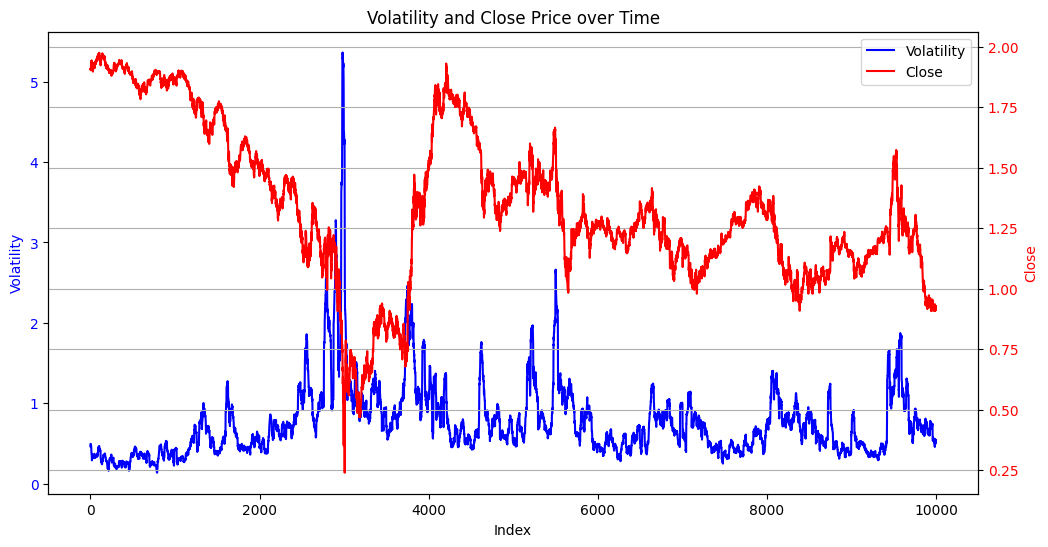

In [4]:
# prompt: plot df['volatility'].iloc[:5000].plot() and 'close', but on different axis

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'volatility' on the primary axis
ax1.plot(df['volatility'].iloc[:10000], label='Volatility', color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Volatility', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary axis for 'close'
ax2 = ax1.twinx()
ax2.plot(df['close'].iloc[:10000], label='Close', color='red')
ax2.set_ylabel('Close', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legend
plt.title('Volatility and Close Price over Time')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.grid(True)
plt.show()

In [5]:
features = ['open', 'high', 'low', 'close', 'volume',
       'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
       'takerBuyQuoteVol', 'ignore', 'Volatility', 'SMA_5', 'EMA_5', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'EMA_50', 'SMA_100', 'EMA_100', 'EMA_200',
       'Std_20', 'Upper_BB', 'Lower_BB', 'Daily_Returns', 'EMA_12', 'EMA_26',
       'MACD', 'Signal', 'prev_return']

Model Architecture

In [6]:
import math
import torch.nn as nn
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # [d_model/2]

        pe[:, 0::2] = torch.sin(position * div_term)  # even dims
        pe[:, 1::2] = torch.cos(position * div_term)  # odd dims
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerReturnPredictor(nn.Module):
    def __init__(self, feature_dim, d_model=64, nhead=4, num_layers=2, max_len=500):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch_size, seq_len, feature_dim]
        x = self.input_proj(x)             # [batch_size, seq_len, d_model]
        x = self.pos_encoder(x)            # Add positional encoding
        x = self.transformer(x)            # [batch_size, seq_len, d_model]
        x = x[:, -1, :]                    # Use representation of last time step
        return self.output_layer(x).squeeze(-1)

class TransformerClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes=3, d_model=64, nhead=4, num_layers=2, max_len=500):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x[:, -1, :]
        return self.output_layer(x)  # [batch_size, num_classes]


Prepare Dataset and dataloader

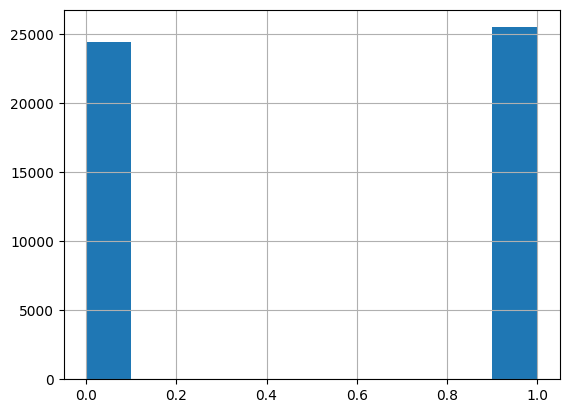

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import accuracy_score

selected_f_all = features
df_scaled = df.iloc[100:50000].copy()
df_scaled['action'] = df_scaled['return_class']
df_scaled['action'].hist()


class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len=20, target_col='target', num_classes=3):
        self.seq_len = seq_len
        self.X = []
        self.y = []

        # data = df.values
        # # data_target = df[['open', 'high', 'low', 'action']].values
        # data_target = df['action'].values
        # features = data[:, :-1]  # all columns except last (assumed target)
        # targets = data_target    # last column is the target

        features = df[selected_f_all].values  # all columns except last (assumed target)
        targets = df['action'].values    # last column is the target

        for i in range(len(df) - seq_len):
            self.X.append(features[i:i+seq_len])
            self.y.append(targets[i+seq_len-1])  # predict the next step

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)  # if it's classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Assumptions:
# - df_scaled is your scaled DataFrame
# - The last column of df_scaled is your class label (0, 1, or 2)
# - You want to predict the class of the next time step

seq_len = 96
input_dim = len(features)
num_classes = 2
batch_size = 32

# Train/val split
# df_scaled = df_scaled_all.iloc[100:40000]
df_scaled = df_scaled.fillna(0)
split = int(0.8 * len(df_scaled))
df_train = df_scaled.iloc[:split]
df_val = df_scaled.iloc[split:]

train_dataset = TimeSeriesDataset(df_train, seq_len=seq_len, num_classes=num_classes)
val_dataset = TimeSeriesDataset(df_val, seq_len=seq_len, num_classes=num_classes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)



Load model

In [9]:
import torch
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
# from dataset import generate_fake_ohlcv_dataset, ReturnClassDataset
# from model import TimesNetClassifier  # assuming you save model in model.py
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare dataset
train_dataset = TimeSeriesDataset(df_train, seq_len=seq_len, num_classes=num_classes)
val_dataset = TimeSeriesDataset(df_val, seq_len=seq_len, num_classes=num_classes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(feature_dim=len(selected_f_all), d_model=128, nhead=8, num_layers=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

Train and Validate model

In [10]:


best_val_acc = 0
epochs_no_improve = 0
patience = 5  # Number of epochs with no improvement to wait
early_stop = False
best_model_state = None

num_epochs = 50  # allow more epochs to benefit from early stopping

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = loss_fn(output, y)
            val_losses.append(loss.item())
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    val_acc = accuracy_score(all_targets, all_preds)

    print(f"\nEpoch {epoch+1}: Train Loss = {sum(train_losses)/len(train_losses):.4f}, "
          f"Val Loss = {sum(val_losses)/len(val_losses):.4f}, "
          f"Val Acc = {val_acc:.4f}")
    print("Classification Report:\n", classification_report(all_targets, all_preds, target_names=['Natural', 'Up']))

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs. Best Val Acc = {best_val_acc:.4f}")
        early_stop = True
        break

# Load best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)



Epoch 1 Validation: 100%|██████████| 309/309 [00:00<00:00, 459.62it/s]



Epoch 1: Train Loss = 0.3070, Val Loss = 0.5519, Val Acc = 0.8182
Classification Report:
               precision    recall  f1-score   support

     Natural       0.43      0.11      0.17      1737
          Up       0.84      0.97      0.90      8147

    accuracy                           0.82      9884
   macro avg       0.63      0.54      0.53      9884
weighted avg       0.76      0.82      0.77      9884



Epoch 2 Validation: 100%|██████████| 309/309 [00:00<00:00, 379.74it/s]



Epoch 2: Train Loss = 0.2897, Val Loss = 0.6027, Val Acc = 0.8362
Classification Report:
               precision    recall  f1-score   support

     Natural       0.55      0.36      0.44      1737
          Up       0.87      0.94      0.90      8147

    accuracy                           0.84      9884
   macro avg       0.71      0.65      0.67      9884
weighted avg       0.82      0.84      0.82      9884



Epoch 3 Validation: 100%|██████████| 309/309 [00:00<00:00, 462.59it/s]



Epoch 3: Train Loss = 0.2821, Val Loss = 0.4434, Val Acc = 0.8278
Classification Report:
               precision    recall  f1-score   support

     Natural       0.57      0.08      0.14      1737
          Up       0.83      0.99      0.90      8147

    accuracy                           0.83      9884
   macro avg       0.70      0.53      0.52      9884
weighted avg       0.79      0.83      0.77      9884



Epoch 4 Validation: 100%|██████████| 309/309 [00:00<00:00, 461.88it/s]



Epoch 4: Train Loss = 0.2791, Val Loss = 0.5811, Val Acc = 0.8220
Classification Report:
               precision    recall  f1-score   support

     Natural       0.39      0.02      0.04      1737
          Up       0.83      0.99      0.90      8147

    accuracy                           0.82      9884
   macro avg       0.61      0.51      0.47      9884
weighted avg       0.75      0.82      0.75      9884



Epoch 5 Validation: 100%|██████████| 309/309 [00:00<00:00, 455.09it/s]



Epoch 5: Train Loss = 0.2707, Val Loss = 0.5951, Val Acc = 0.8315
Classification Report:
               precision    recall  f1-score   support

     Natural       0.53      0.33      0.41      1737
          Up       0.87      0.94      0.90      8147

    accuracy                           0.83      9884
   macro avg       0.70      0.64      0.66      9884
weighted avg       0.81      0.83      0.82      9884



Epoch 6 Validation: 100%|██████████| 309/309 [00:00<00:00, 460.69it/s]



Epoch 6: Train Loss = 0.2688, Val Loss = 0.6271, Val Acc = 0.8213
Classification Report:
               precision    recall  f1-score   support

     Natural       0.44      0.06      0.11      1737
          Up       0.83      0.98      0.90      8147

    accuracy                           0.82      9884
   macro avg       0.64      0.52      0.50      9884
weighted avg       0.76      0.82      0.76      9884



Epoch 7 Validation: 100%|██████████| 309/309 [00:00<00:00, 464.61it/s]


Epoch 7: Train Loss = 0.2622, Val Loss = 0.7366, Val Acc = 0.8291
Classification Report:
               precision    recall  f1-score   support

     Natural       0.52      0.31      0.39      1737
          Up       0.86      0.94      0.90      8147

    accuracy                           0.83      9884
   macro avg       0.69      0.63      0.65      9884
weighted avg       0.80      0.83      0.81      9884


Early stopping triggered after 7 epochs. Best Val Acc = 0.8362
